In [2]:
import gc
from pathlib import Path
import torch 
from tqdm import tqdm
import torch_geometric 
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from faenet.transforms import FrameAveraging
from faenet.fa_forward import model_forward
from faenet.model import FAENet

In [6]:
import numpy as np
import random
import argparse
import torch 
import torch.nn as nn
from torch.autograd import grad 
import torch_geometric 
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn.pool import global_add_pool
import sys 
import time
import wandb
from tqdm import tqdm
sys.path.append("faenet/")
from faenet.transforms import FrameAveraging
from faenet.fa_forward import model_forward
from faenet.model import FAENet

In [3]:
dataset = torch.load("/home/distileq/home/code/EGNN/Datasets/aspirin/train_full_pyg.pth")
dataset[0]

Data(edge_index=[2, 298], cell=[3, 3], charges=[21], energy=-17635.845703125, energy_weight=1.0, forces=[21, 3], forces_weight=1.0, node_attrs=[21, 3], positions=[21, 3], shifts=[298, 3], stress=[1, 3, 3], stress_weight=0.0, unit_shifts=[298, 3], virials=[1, 3, 3], virials_weight=0.0, weight=1.0)

In [4]:
# FAENet transforms 
frame_averaging = "3D"  # symmetry preservation method used: {"3D", "2D", "DA", ""}:
fa_method = "stochastic"  # the frame averaging method: {"det", "all", "se3-stochastic", "se3-det", "se3-all", ""}:
transform = FrameAveraging(frame_averaging, fa_method)

def one_hot_to_atomic_number(data):
    atomic_number_map = {
        # (1., 0.): 1,
        # (0., 1.): 6
        (1., 0., 0.): 1,  # Li, H
        (0., 1., 0.): 6,  # P, C
        (0., 0., 1.): 8   # S, O 
    }
    atomic_numbers = [atomic_number_map[tuple(one_hot)] for one_hot in data['node_attrs'].tolist()]
    return torch.tensor(atomic_numbers)

def preprocess_to_faenet_format(dataset):
    fae_dataset = []
    for data in tqdm(dataset, desc="preprocessing..."):
        fae_data = Data(
            edge_index = data['edge_index'],
            neighbors = data['edge_index'].shape[1], 
            pos = data.positions, 
            cell = data.cell, 
            images = data.unit_shifts,
            cell_offsets = data.shifts,
            energy = data.energy, 
            forces = data.forces, 
            atomic_numbers = one_hot_to_atomic_number(data)
        )
        fae_dataset.append(transform(fae_data))
    return fae_dataset

In [5]:
dataset_fae = preprocess_to_faenet_format(dataset)
dataset_fae[0]

preprocessing...: 100%|██████████| 950/950 [00:00<00:00, 1185.68it/s]


Data(edge_index=[2, 298], pos=[21, 3], neighbors=298, cell=[3, 3], images=[298, 3], cell_offsets=[298, 3], energy=-17635.845703125, forces=[21, 3], atomic_numbers=[21], fa_pos=[1], fa_cell=[1], fa_rot=[1])

In [10]:
device = torch.device("cuda")
train_loader = DataLoader(dataset_fae, batch_size=10, shuffle=True)
model = FAENet(
                    cutoff=5.0, 
                    preprocess='pbc_preprocess', 
                    regress_forces="direct",
                    tag_hidden_channels=0,
                    num_interactions=2,
                ).to(device)


### uncomment this for forward pass
batch = next(iter(train_loader)).to(device)
preds = model_forward(
            batch=batch, 
            model=model,
            frame_averaging="3D",
            mode="train",
            crystal_task=True
            )


In [12]:
preds["forces"]

tensor([[ 2.1931e-01,  2.3044e-01, -3.5556e-01],
        [ 2.3174e-01,  4.5223e-02, -5.1001e-01],
        [-5.9730e-02,  3.5598e-01, -4.2799e-02],
        [-5.3664e-03,  4.2075e-01, -2.6116e-01],
        [ 2.4794e-01, -2.0699e-01,  5.4117e-01],
        [ 3.6230e-01, -6.7991e-02, -5.5640e-01],
        [ 5.0330e-01, -3.2229e-01, -3.6882e-01],
        [-4.1452e-03, -1.8250e-01,  2.0502e-01],
        [ 4.5934e-03, -1.0210e+00, -2.5901e-01],
        [-2.8195e-01,  4.8981e-02, -2.6800e-01],
        [ 2.1408e-01, -2.6061e-02, -7.9928e-01],
        [ 5.0035e-01, -8.8986e-02, -4.2726e-02],
        [ 1.9741e-01,  8.5569e-03, -2.3273e-02],
        [ 4.9554e-01, -2.5423e-01,  7.0005e-02],
        [ 3.9314e-02,  1.0997e-01, -2.2208e-01],
        [-5.7712e-02, -2.1057e-01, -1.8964e-01],
        [-1.3423e-01,  1.7919e-01, -1.6666e-01],
        [-2.5824e-01,  1.2860e-01,  3.3159e-01],
        [ 4.4444e-02, -3.4341e-01,  1.2368e+00],
        [ 4.7230e-01, -3.9451e-01,  3.0235e-01],
        [ 6.8641e-01

In [13]:
def loss_fn(pred_forces, batch):
    if 'is_root' in batch:
        root_nodes = batch['is_root']
        return torch.mean(torch.square(batch["forces"][root_nodes] - pred_forces[root_nodes]))
    else:
        return torch.mean(torch.square(batch["forces"] - pred_forces))

In [14]:
model.train()
train_loss = 0
train_epoch_losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in tqdm(range(10)):
    train_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        preds = model_forward(
            batch=batch, 
            model=model,
            frame_averaging="3D",
            mode="train",
            crystal_task=True)
        pred_forces = preds["forces"]
        loss = loss_fn(pred_forces, batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().detach().item()
    train_epoch_losses.append(train_loss / len(train_loader))
    # print(f"Epoch: {epoch + 1}, Train loss: {train_loss / len(train_loader)}")

100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


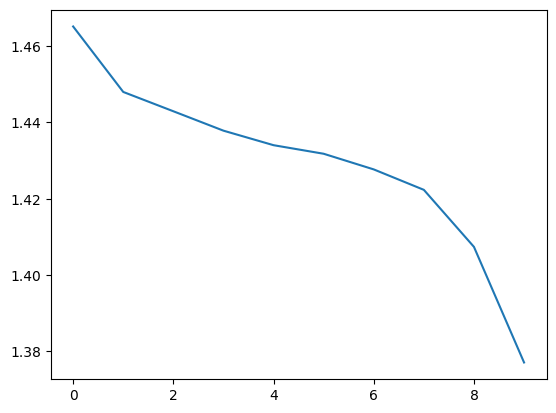

In [17]:
import matplotlib.pyplot as plt 

plt.plot(list(range(10)), train_epoch_losses)
plt.show()